# NDVI time series analysis

Given that we have field delineations in the form of polygon geometries, we can perform time-series analyses with NDVI on a number (if not all) field polygons inside the buffer of distributor regions. Using NDVI time-series data, we can start identifying trends and seasonalities and determine cropping/planting cycles in the different regions. Performing time-series analyses on the polygons can also help us on two important areas -

* Time-series data also be used to mask polygons that are not farm land. Polygons which consistently display low NDVI values will be characteristic of regions with very little or not vegetation.
* Disruptions in the seasonality can also hint at factors that may have hindered crop yields.

Here, we test out time-series data generation for a sample polygon in the Trans-Nzoia region.

In [1]:
import os 
from dotenv import load_dotenv
import numpy as np
import geopandas as gpd
import ee
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
plt.rc('axes', linewidth=2)

import warnings
warnings.filterwarnings('ignore')

In [2]:
load_dotenv()
GEE_PROJECT = os.getenv("GEE_PROJECT")

ee.Authenticate()
ee.Initialize(project=GEE_PROJECT)

## Data

The polygon `.gpkg` file is uploaded for the Trans-Nzoia region and filtered for only `tile_0`.

In [3]:
gdf = gpd.read_file("/Users/rafidmahbub/Desktop/DataKind_Geospatial/samgeo_aws_ec2/vectors/Kajiado_1.gpkg")

gdf_filtered = gdf[
    gdf["tile_name"] == "tile_0"
]

gdf_filtered.head()

,uuid,region,tile_name,area (sq. meters),area (acres),geometry
10519,d0e5f9a8-1ed6-4f3d-b335-1cce143a855b,Kajiado_1,tile_0,100.501909,0.024824,"POLYGON ((37.43204 -2.8747, 37.43204 -2.87474,..."
10520,b76780b7-23dd-470d-9a06-af4a15831629,Kajiado_1,tile_0,25.125478,0.006206,"POLYGON ((37.45042 -2.87474, 37.45042 -2.87479..."
10521,6f39675b-d2e8-4aa0-81db-893d9f0aada8,Kajiado_1,tile_0,25.125478,0.006206,"POLYGON ((37.45249 -2.87474, 37.45249 -2.87479..."
10522,7ae99876-1089-4fc9-bd96-6f2117a557d3,Kajiado_1,tile_0,50.809303,0.012550,"POLYGON ((37.45245 -2.87479, 37.45245 -2.87488..."
10523,db9e76fb-1d89-4a9d-87fc-e2120bcb0934,Kajiado_1,tile_0,25.125480,0.006206,"POLYGON ((37.45038 -2.87484, 37.45038 -2.87488..."


In [4]:
map = gdf_filtered.explore(tiles="Esri.WorldImagery")
display(map)

## Define functions

Here, we define a few important functions

* `search_polygons()`: This function allows to us search for polygons given only a subset of `uuid`. This for easy selection from an interactive plot.
* `return_gee_geometry()`: Since the polygon data are in incompatible with GEE, this function converts it to a `ee.Geometry` object.
* `mask_cloud_and_shadow()`: This function masks out pixels which are supposed to be clouds and cloud shadows.

In [25]:
def search_polygon(gdf: gpd.GeoDataFrame, id: str) -> np.ndarray:
    """ 
    This function returns a polygon's full uuid by matching the
    first n characters in it.

    Args: (i) gdf - geopandas dataframe containing polygons
          (ii) id - starting uuid substring

    Returns: uuid value(s)
    """

    # Match the starting string id with the uuid column and return match(es)
    n = len(id)
    uuid_df = gdf[["uuid"]]
    uuid_df["match"] = uuid_df["uuid"].apply(lambda row: row[0:n] == id)
    
    idx = uuid_df[uuid_df["match"]==True].index.values.tolist()

    if len(idx) == 0:
        print("No matches found.")

    elif len(idx) >= 1:
        uuid = uuid_df.loc[idx, "uuid"]
        return uuid.values

def return_gee_geometry(gdf: gpd.GeoDataFrame, uuid: str) -> ee.Geometry:
    """ 
    This function converts the polygon geometry associated with a uuid
    to a GEE geometry object. 

    Args: (i) gdf - geopandas dataframe
          (ii) uuid - the polygon uuid for filtering

    Returns: the polygon geometry in the form of an ee.Geometry object
    """
    gdf_RoI = gdf[gdf["uuid"] == uuid]
    RoI = ee.Geometry(gdf_RoI.to_geo_dict()["features"][0]["geometry"])

    return RoI

def mask_cloud_and_shadow(img: ee.Image) -> ee.Image:
    """ 
    This function creates a pixel mask that are deemed to be cloud
    and (or) cloud shadow using Sentinel-2 `MSK_CLDPRB` and
    `Scene Classification Layer`.

    Args: img - ee.Image object

    Returns: same ee.Image object with an updated mask
    """
    cloud_prob = img.select("MSK_CLDPRB")
    snow_prob = img.select("MSK_SNWPRB")
    cloud = cloud_prob.lt(30)
    snow = snow_prob.lt(30)

    # Use SCL to select shadows and cirrus cloud masks
    scl = img.select("SCL")
    shadow = scl.eq(3)
    cirrus = scl.eq(10)

    mask = (
        cloud.And(snow)
        .And(cirrus.neq(1))
        .And(shadow.neq(1))
    )

    return img.updateMask(mask)

def add_NDVI(img: ee.Image) -> ee.Image:
    """ 
    This function takes an ee.Image object and adds an NDVI band to it.

    Args: img - ee.Image object

    Returns: same ee.Image object with an NDVI band 
    """
    ndvi = img.normalizedDifference(["B8", "B4"]).rename("ndvi")
    return img.addBands([ndvi])
    
uuid = search_polygon(gdf, "085106")[0]
RoI = return_gee_geometry(gdf, uuid)

## Image filtering and NDVI time-series calculation

Using the `S2_SR_HARMONIZED` image collection, we filter the image collection between `START_DATE` and `END_DATE` over a period of three years. The image collection is futher filtered using the RoI and the `mask_cloud_and_shadow()` and `add_NDVI()` functions are subsequently added such that each image in the collection are update with the cloud mask and NDVI band. 

To obtain a time-series, the image collection is converted into a feature collection where the NDVI is average over the polygon in question using the `ee.Reducer.mean()` method. Since cloud masking is applied, we may end up with 'null' values from time to time. These null values are replaced with -9999, which can be later identified from the dataset.

In [26]:
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

img_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate(START_DATE, END_DATE)
    .map(mask_cloud_and_shadow)
    .map(add_NDVI)
    .filter(ee.Filter.bounds(RoI))
).select("ndvi")

def map_ndvi(img: ee.Image) -> ee.Feature:
    stats = img.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=RoI,
        scale=10,
        crs="EPSG:4326"
    )

    ndvi = ee.List([stats.get("ndvi"), -9999]).reduce(ee.Reducer.firstNonNull())
    date = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")

    return ee.Feature(
        None, {
            "ndvi": ndvi,
            "date": date
        }
    )

time_series = ee.FeatureCollection(img_collection.map(map_ndvi))

In [27]:
# Extracting NDVI time-series without uploading to Google Drive

def ndvi_series_df(time_series: ee.FeatureCollection) -> pd.DataFrame:
    """ 
    This function converts GEE NDVI time-series data into a dataframe. This function
    is intended to extract time-series data for single polygons. Collections of 
    polygons should be exported to cloud using ee.batch.Export methods.

    Args: time_series - the NDVI time-series data in the form of ee.FeatureCollection object

    Returns: the NDVI time-series as a pandas dataframe
    """

    # The initial dataframe will contain a dictionary-valued `properties` column
    df = (
        pd.DataFrame(time_series.getInfo()["features"])
        .drop(columns=["type", "geometry"])
    )

    # # The properties column is unpacked
    df[["date", "ndvi"]] = df["properties"].apply(pd.Series)
    df["date"] = pd.to_datetime(df["date"])
    df = df.drop(columns=["properties"])

    # start_date = pd.to_datetime("2022-01-01")
    # df["days_elapsed"] = df["date"].apply(lambda row: (row - start_date).days)
    # df["days_elapsed"] = df["days_elapsed"].astype("Int32")

    return df

Export time-series data to Google Drive.

In [8]:
# task = ee.batch.Export.table.toDrive(
#     collection=time_series,
#     description='ndvi_time_series',
#     folder='ee_demos',
#     fileFormat='CSV',
# )
# task.start()

## Sample NDVI time-series plot

Now, we can plot the sample NDVI time-series. Pre-processing steps include converting the `date` into pandas `datetime` objects and filtering the data for the -9999 null values.

In [28]:
#ndvi_series = pd.read_csv("ndvi_time_series.csv")
ndvi_series = ndvi_series_df(time_series)

ndvi_series = ndvi_series[ndvi_series["ndvi"] != -9999.000000]
ndvi_series["date"] = pd.to_datetime(ndvi_series["date"])
ndvi_series = ndvi_series.drop_duplicates(subset=["date"], keep="first")
ndvi_series.head()

,id,date,ndvi
0,20200104T074311_20200104T074313_T37MCS,2020-01-04,0.219253
5,20200129T074049_20200129T075021_T37MCS,2020-01-29,0.338500
6,20200203T074121_20200203T075837_T37MCS,2020-02-03,0.588200
7,20200208T074009_20200208T075621_T37MCS,2020-02-08,0.525666
8,20200213T074021_20200213T075201_T37MCS,2020-02-13,0.451363


The time-series is not regularly spaced. We see that, even though a majority of the time steps are 5 days apart, there are some irregularites. This can create problems with time-series analysis and model training. The data can be resampled to a 5 day interval one and new values filled in using interpolation.

In [29]:
diffs = ndvi_series["date"].diff().value_counts() 

print(diffs)

len(diffs.index)

date
5 days     84
10 days    39
15 days    17
20 days     7
35 days     5
25 days     4
45 days     2
40 days     2
30 days     2
50 days     1
55 days     1
Name: count, dtype: int64


11

In [32]:
ndvi_series_resampled = (
    ndvi_series.set_index("date").resample("5D")
               .interpolate(method="linear")
)

In [33]:
ndvi_series_resampled.reset_index()

,date,id,ndvi,ndvi_smoothed
0,2020-01-04,20200104T074311_20200104T074313_T37MCS,0.219253,0.209843
1,2020-01-09,NaN,0.243103,0.246050
2,2020-01-14,NaN,0.266952,0.282256
3,2020-01-19,NaN,0.290802,0.318463
4,2020-01-24,NaN,0.314651,0.354670
...,...,...,...,...
359,2024-12-03,NaN,0.260093,0.253825
360,2024-12-08,NaN,0.288112,0.266801
361,2024-12-13,20241213T074229_20241213T075457_T37MCS,0.316130,0.279776
362,2024-12-18,20241218T074331_20241218T075552_T37MCS,0.370491,0.354937


The NDVI data obtained from GEE will be noisy for various reasons. Apart from the fact that these are estimates based on pixel-aggregations over the polygons, levels of cloud-masking used will undoubtedly affect the quality of the time-series data. To miitgate some of these difficulties, we apply a 'Savitzky-Golay' filter to smooth out the time-series data. The filtering process also handles most of the outlier points.

In [30]:
from scipy.signal import savgol_filter

ndvi_series["ndvi_smoothed"] = savgol_filter(x=ndvi_series["ndvi"], window_length=7, polyorder=3)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
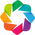

:Overlay
   .Scatter.Raw                                :Scatter   [index]   (ndvi)
   .Curve.I                                    :Curve   [index]   (ndvi)
   .Scatter.Savitzky_hyphen_minus_Golay_filter :Scatter   [index]   (ndvi_smoothed)
   .Curve.II                                   :Curve   [index]   (ndvi_smoothed)

In [31]:
import holoviews as hv
hv.extension('bokeh')

s1 = hv.Scatter(ndvi_series["ndvi"], label="raw").opts(size=8, line_color="black", tools=["hover"])
c1 = hv.Curve(ndvi_series["ndvi"])
s2 = hv.Scatter(ndvi_series["ndvi_smoothed"], label="Savitzky-Golay filter").opts(size=8, line_color="black", tools=["hover"])
c2 = hv.Curve(ndvi_series["ndvi_smoothed"])

overlay = s1*c1*s2*c2

overlay.opts(
    width=1050,
    height=500,
    show_grid=True,
    title="Sample NDVI time-series"
)
#hv.save(overlay, 'sample_ndvi_timeseries_transnzoia.png', dpi=300, fmt="png")
overlay

In [35]:
s3 = hv.Scatter(ndvi_series_resampled["ndvi"], label="raw").opts(size=8, line_color="black", tools=["hover"])
c3 = hv.Curve(ndvi_series_resampled["ndvi"])
s4 = hv.Scatter(ndvi_series_resampled["ndvi_smoothed"], label="Savitzky-Golay filter").opts(size=8, line_color="black", tools=["hover"])
c4 = hv.Curve(ndvi_series_resampled["ndvi_smoothed"])

overlay2 = s3*c3*s4*c4

overlay2.opts(
    width=1050,
    height=500,
    show_grid=True,
    title="Sample NDVI time-series"
)
#hv.save(overlay, 'sample_ndvi_timeseries_transnzoia.png', dpi=300, fmt="png")
overlay2

:Overlay
   .Scatter.Raw                                :Scatter   [date]   (ndvi)
   .Curve.I                                    :Curve   [date]   (ndvi)
   .Scatter.Savitzky_hyphen_minus_Golay_filter :Scatter   [date]   (ndvi_smoothed)
   .Curve.II                                   :Curve   [date]   (ndvi_smoothed)

### Converting `shapely.geometry` objects into `ee.Geometry` objects

Geometries stored in geopandas are created using `shapely.geometry` objects. However, GEE uses the geojson format for storing geometric information. As a first step, the `geometry` column is mapped into an `ee.Geometry` column. These can then be aggregated into an `ee.FeatureCollection` object with attached metadata.

In [14]:
import json
import shapely
from shapely.geometry import Polygon 

def return_ee_geometry(poly: Polygon) -> ee.Geometry:
        # shapely.to_geojson() returns a string object which needs to be
        # converted to geojson before using with ee.Geometry
        RoI = ee.Geometry(json.loads(shapely.to_geojson(poly)))

        return RoI

gdf_filtered["RoI"] = gdf_filtered["geometry"].apply(return_ee_geometry)

gdf_filtered.head()

,uuid,region,tile_name,area (sq. meters),area (acres),geometry,RoI
27517,b7627b92-5a06-4521-beeb-863c65ee8764,Trans_Nzoia_1,tile_0,25.097259,0.006199,"POLYGON ((34.91154 0.94319, 34.91154 0.94314, ...","ee.Geometry({\n ""functionInvocationValue"": {\..."
27518,57dfc2af-ca3c-48ee-9efb-421e6453959a,Trans_Nzoia_1,tile_0,99.831319,0.024658,"POLYGON ((34.91244 0.94319, 34.91244 0.94314, ...","ee.Geometry({\n ""functionInvocationValue"": {\..."
27519,a5bb14bb-cea3-48ab-9325-0890b504433a,Trans_Nzoia_1,tile_0,74.734060,0.018459,"POLYGON ((34.91302 0.94319, 34.91302 0.94314, ...","ee.Geometry({\n ""functionInvocationValue"": {\..."
27520,9d0c1329-3643-4a95-bda7-51560d154104,Trans_Nzoia_1,tile_0,25.654976,0.006337,"POLYGON ((34.9115 0.94314, 34.9115 0.9431, 34....","ee.Geometry({\n ""functionInvocationValue"": {\..."
27521,91b3d38e-b77a-494e-bc60-065ce829a0a4,Trans_Nzoia_1,tile_0,25.654976,0.006337,"POLYGON ((34.92439 0.94314, 34.92439 0.9431, 3...","ee.Geometry({\n ""functionInvocationValue"": {\..."


### Creating `FeatureCollection` from RoIs

All the RoI geometries are aggregated into an `ee.FeatureCollection` object.

In [15]:
def gdf_to_FC(gdf: gpd.GeoDataFrame) -> ee.FeatureCollection:
    """ 
    This function converts each RoI in the geodataframe into an
    ee.Feature object with attached metadata. All the features are
    then aggregated into an ee.FeatureCollection object.
    """
    features = []

    for idx, row in gdf.iterrows():
        feature = ee.Feature(row["RoI"])
        metadata = {
            "region": row["region"],
            "tile_name": row["tile_name"],
            "uuid": row["uuid"]
        }
        feature = feature.set(metadata)

        features.append(feature)
    
    return ee.FeatureCollection(features)

FC = gdf_to_FC(gdf_filtered)

### Map NDVI function over all images

The image collection, after being filtered, is passed through the `map_ndvi()` function, which applies the reducer to all the images for calculating the spatially averaged NDVI. The NDVI data for all the images are processed into a table that is exported to Google Drive.

In [16]:
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

img_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate(START_DATE, END_DATE)
    .filterBounds(FC)
    .map(mask_cloud_and_shadow)
    .map(add_NDVI)
).select("ndvi")

def clip_img_collection(img: ee.Image) -> ee.Image:
    return img.clip(FC)

img_collection_clipped = img_collection.map(clip_img_collection)

def map_ndvi(img: ee.Image):
    stats =img.reduceRegions(
        collection=FC,
        reducer=ee.Reducer.mean().setOutputs(["ndvi"]),
        scale=10
    ).filter(ee.Filter.neq("ndvi", None)) # Filter out null NDVI values

    def set_date(feature: ee.Feature):
        return feature.set("date", img.date().format("YYYY-MM-dd"))
    
    return stats.map(set_date)
# def map_ndvi(img: ee.Image) -> ee.Feature:
#     stats = img.reduceRegion(
#         reducer=ee.Reducer.mean(),
#         geometry=RoI,
#         scale=10
#     )

#     ndvi = ee.List([stats.get("ndvi"), -9999]).reduce(ee.Reducer.firstNonNull())
#     date = ee.Date(img.get("system:time_start")).format("YYYY-MM-dd")

#     return ee.Feature(
#         None, {
#             "ndvi": ndvi,
#             "date": date
#         }
#     )

data = img_collection_clipped.map(map_ndvi).flatten()

In [17]:
def format_table(table, row_id, col_id):
    # Get unique rows based on rowId
    rows = table.distinct(row_id)

    # Create join condition
    condition = ee.Filter.equals(leftField=row_id, rightField=row_id)

    # Perform the join
    joined = ee.Join.saveAll('matches').apply(primary=rows, secondary=table, condition=condition)

    # Map over joined results
    def map_row(row):
        matches = ee.List(row.get('matches'))

        def extract_values(feature):
            feature = ee.Feature(feature)
            ndvi_val = ee.List([feature.get('ndvi'), -9999]).reduce(ee.Reducer.firstNonNull())
            return [feature.get(col_id), ee.Number(ndvi_val).format('%.3f')]

        # Get list of [colId, ndvi] pairs
        values = matches.map(extract_values)

        # Flatten and convert to dictionary
        flat_values = ee.Dictionary(ee.List(values).flatten())

        # Return row with the wide-format values added
        return row.select([row_id]).set(flat_values)

    return ee.FeatureCollection(joined.map(map_row))

NDVI_Results = format_table(data, 'uuid', 'date')

In [18]:
# task = ee.batch.Export.table.toDrive(
#     collection=NDVI_Results,
#     description='NDVI_Results',
#     folder='ee_demos',
#     fileFormat='CSV',
# )
# task.start()

In [19]:
#task.status()

### Cleaning and imputation

The table exported to Google Drive is exported in a format where each row corresponds to the polygons contained in the geometries and the columns containing the dates in `string` format. Moreover, the data contains numerous `NaN` values. These are imputed using the `bfill` method. However, there may be rows where the final NDVI entry are missing. In such cases, they are filled using `ffill`. Then, the dataframe is melted such that date columns are now stored in rows with all the polygon data appended to each other, in a sorted fashion.

**Update:** Using `interpolate()` to fill in NaN values has proven to be a better alternative.

In [4]:
# def fill_dates(row: pd.Series) -> pd.Series:
#     """ 
#     This function implements a smart imputation strategy such that
#     rows with missing entries at starting date is imputed with `bfill`
#     while those with missing entries at the end are imputed with `ffill`.
#     For others, it defaults to `bfill`.
#     """
#     if pd.isna(row.iloc[0]):
#         row = row.fillna(method="bfill")
#         return row
#     elif pd.isna(row.iloc[-1]):
#         row = row.fillna(method="ffill")
#         return row
#     else:
#         row = row.fillna(method="bfill")
#         return row

def clean_ndvi_series(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=["system:index", ".geo"]) # Remove useless columns

    uuid_col = df.columns[-1]
    new_cols = [uuid_col] + list(df.columns[:-1])
    df = df.reindex(columns=new_cols)

    # Isolate only the numerical portion of the dataframe
    #df.iloc[:, 1:] = df.iloc[:, 1:].apply(fill_dates, axis=1)
    df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method="linear", axis=1)

    df_melted = (
        df.melt(id_vars="uuid", var_name="date", value_name="ndvi")
          .groupby("uuid", group_keys=False).apply(lambda row: row.sort_values(by="date", ascending=False))
    )
    df_melted["date"] = pd.to_datetime(df_melted["date"])
    df_melted = df_melted.drop_duplicates(subset=["uuid", "date"], keep="first")

    return df_melted.reset_index(drop=True)

In [7]:
ndvi_series_tile_0 = pd.read_csv("/Users/rafidmahbub/Desktop/DataKind_Geospatial/crop_classification/time_series_analyses/ndvi_series_raw/ndvi_series_Trans_Nzoia_1_tile_0.csv")
ndvi_series_tile_0 = clean_ndvi_series(ndvi_series_tile_0)
ndvi_series_tile_0

,uuid,date,ndvi
0,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-26,0.3270
1,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-16,0.3455
2,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-11,0.3640
3,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-06,0.3590
4,000f5041-32c0-4a8a-b139-83bf4845d9e6,2024-12-01,0.1200
...,...,...,...
524155,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-02-11,0.5600
524156,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-01-22,0.4490
524157,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-01-17,0.4590
524158,ffe88305-d0d2-446f-9674-60ea1fd8be85,2020-01-12,0.3520


In [22]:
#ndvi_series_tile_0.groupby("uuid")["date"].apply(lambda x: len(x.diff().value_counts()))

All NaN values have been properly imputed.

In [23]:
ndvi_series_tile_0.isna().value_counts()

uuid   date   ndvi 
False  False  False    524160
Name: count, dtype: int64

In [5]:
# Apply resampling and interpolate

def date_resample(df: pd.DataFrame) -> pd.DataFrame:
    """ 
    This function performs resampling on chunks of the dataframe (based on uuid)
    to remove irregular time samples by resample to 5 day intervals and interpolating
    the additional fields.
    """
    if len(df["date"].diff().value_counts()) > 1:
        # If there are multiple `periods` in the data

        df = (
            df.set_index("date").resample("5D")
              .asfreq()
        )

        df[["ndvi", "ndvi_smoothed"]] = df[["ndvi", "ndvi_smoothed"]].interpolate()
        df["uuid"] = df["uuid"].fillna(df["uuid"].mode()[0])

        return df.reset_index()
    else:
        return df

In [10]:
groups = []
for idx, group in ndvi_series_tile_0.groupby("uuid"):
    group["ndvi_smoothed"] = savgol_filter(group["ndvi"], window_length=7, polyorder=3)
    groups.append(date_resample(group))

ndvi_series_tile_0 = pd.concat(groups)

In [11]:
ndvi_series_tile_0

,date,uuid,ndvi,ndvi_smoothed
0,2020-01-02,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.6610,0.655667
1,2020-01-07,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.6580,0.661512
2,2020-01-12,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.6550,0.667357
3,2020-01-17,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.5970,0.605786
4,2020-01-22,000f5041-32c0-4a8a-b139-83bf4845d9e6,0.5590,0.506952
...,...,...,...,...
360,2024-12-06,ffe88305-d0d2-446f-9674-60ea1fd8be85,0.5680,0.571762
361,2024-12-11,ffe88305-d0d2-446f-9674-60ea1fd8be85,0.5730,0.563071
362,2024-12-16,ffe88305-d0d2-446f-9674-60ea1fd8be85,0.5320,0.537786
363,2024-12-21,ffe88305-d0d2-446f-9674-60ea1fd8be85,0.5115,0.513845


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
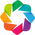

Output()

:Overlay
   .Scatter.Raw                         :Scatter   [date]   (ndvi)
   .Curve.I                             :Curve   [date]   (ndvi)
   .Scatter.Savitzky_hyphen_minus_Golay :Scatter   [date]   (ndvi_smoothed)
   .Curve.II                            :Curve   [date]   (ndvi_smoothed)

Output()

In [12]:
import holoviews as hv
hv.extension('bokeh')

import ipywidgets as widgets
from IPython.display import display, clear_output

# Outputs for plotting and map
plot_out = widgets.Output()
map_out = widgets.Output()

# Plot function
def plot_timeseries(uuid: str):
    df_subset = ndvi_series_tile_0[
        ndvi_series_tile_0["uuid"] == uuid
    ].set_index("date")

    with plot_out:
        plot_out.clear_output(wait=True)

        # HoloViews plot
        s1 = hv.Scatter(df_subset["ndvi"], label="raw").opts(size=8, line_color="black", tools=["hover"])
        c1 = hv.Curve(df_subset["ndvi"])
        s2 = hv.Scatter(df_subset["ndvi_smoothed"], label="Savitzky-Golay").opts(size=8, line_color="black", tools=["hover"])
        c2 = hv.Curve(df_subset["ndvi_smoothed"])
        overlay_1 = (s1 * c1 * s2 * c2).opts(width=1050, height=400, show_grid=True, title="NDVI Time Series")
        display(overlay_1)

    with map_out:
        map_out.clear_output(wait=True)

        # Folium/GeoPandas map
        gdf_subset = gdf[gdf["uuid"] == uuid]
        if not gdf_subset.empty:
            fmap = gdf_subset.explore(tiles="Esri.WorldImagery", color="red", zoom=15)
            display(fmap)

# Widgets
uuid_list = ndvi_series_tile_0["uuid"].unique().tolist()
uuid_dropdown = widgets.Dropdown(options=uuid_list, description="UUID:")
label_text = widgets.Text(description="Label")
save_button = widgets.Button(description="Save Label", button_style="success")

labels_dict = {}

def save_label(b):
    current_uuid = uuid_dropdown.value
    label = label_text.value
    labels_dict[current_uuid] = label
    print(f"Saved label for {current_uuid}: {label}")

save_button.on_click(save_label)

# UI layout
ui = widgets.HBox([uuid_dropdown, label_text, save_button])
uuid_dropdown.observe(lambda change: plot_timeseries(change['new']), names='value')

# Initial display
display(ui, plot_out, map_out)
plot_timeseries(uuid_list[0])  # Load first plot by default

In [217]:
labels_df = pd.DataFrame.from_dict(labels_dict, orient="index")
labels_df.rename(columns={0: "class"}, inplace=True)

labels_df["class"] = labels_df["class"].apply(lambda x: "Field" if x=="FIeld" or x=="Feld" else x)
labels_df = labels_df.reset_index(names="uuid")
#labels_df.to_csv("Trans_Nzoia_1_tile_0_NDVI_labels.csv")

In [218]:
labels_count_df = labels_df["class"].value_counts().reset_index()

bar = hv.Bars(labels_count_df, kdims="class", vdims="count").opts(
    color="class",
    cmap='Category10', 
    line_color="black",
    line_width=2,
    width=600,
    height=400,
    title="Trans Nzoia tile_0 labels",
    tools=["hover"]
)

bar

:Bars   [class]   (count)

In [251]:
gdf_filtered = pd.merge(
    gdf_filtered,
    labels_df,
    on="uuid",
    how="left"
)

m = gdf_filtered.explore(column="class", tiles="Esri.WorldImagery")
m